In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import h5py
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

import seaborn as sns
import matplotlib.pyplot as plt

/Users/edgardocrovetto/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Cargar el archivo HDF5
with h5py.File('dataset_y_clasificacion.h5', 'r') as hdf:
    imagenes = np.array(hdf['images'])  # Cargar las imágenes
    etiquetas = np.array(hdf['classification'])  # Cargar las etiquetas (one-hot encoded)

In [6]:
# Dividir el conjunto de datos en entrenamiento (70%) y resto (30%)
X_train, X_temp, y_train, y_temp = train_test_split(imagenes, etiquetas, test_size=0.30, random_state=42)

# Dividir el resto en validación (10%) y prueba (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=42)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de validación: {X_val.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")


Tamaño del conjunto de entrenamiento: (4214, 112, 112, 3)
Tamaño del conjunto de validación: (596, 112, 112, 3)
Tamaño del conjunto de prueba: (1211, 112, 112, 3)


In [9]:
# Definir el modelo CNN para probabilidad de lesión maligna
model_cnn_porcentaje_simple = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(112, 112, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Usamos una única neurona con activación sigmoide
])

# Compilar el modelo
model_cnn_porcentaje_simple.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Mostrar el resumen del modelo
model_cnn_porcentaje_simple.summary()

/Users/edgardocrovetto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 110, 110, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 53, 53, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,452,801 (9.36 MB)

 Trainable params: 2,452,801 (9.36 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

# Asegurarse de que las etiquetas son binarias
y_train_binary = np.argmax(y_train, axis=1)  # De one-hot encoding a 0 o 1
y_val_binary = np.argmax(y_val, axis=1)
y_test_binary = np.argmax(y_test, axis=1)

# Definir el modelo CNN con una salida sigmoide para probabilidades
model_cnn_simple = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(112, 112, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Activación sigmoide para probabilidad de lesión maligna
])

# Compilar el modelo
model_cnn_simple.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model_cnn_simple.fit(X_train, y_train_binary, epochs=25, batch_size=32, validation_data=(X_val, y_val_binary))


/Users/edgardocrovetto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.5498 - loss: 0.7313 - val_accuracy: 0.6124 - val_loss: 0.5974
Epoch 2/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.6225 - loss: 0.5939 - val_accuracy: 0.6493 - val_loss: 0.5493
Epoch 3/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 0.6892 - loss: 0.5573 - val_accuracy: 0.6678 - val_loss: 0.5268
Epoch 4/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.7417 - loss: 0.4849 - val_accuracy: 0.7718 - val_loss: 0.4849
Epoch 5/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 22s 165ms/step - accuracy: 0.7386 - loss: 0.4702 - val_accuracy: 0.7953 - val_loss: 0.4547
Epoch 6/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.7585 - loss: 0.4590 - val_accuracy: 0.7383 - val_loss: 0.5415
Epoch 7/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - accuracy: 0.7502 - loss: 0.4690 - val_accuracy: 0.7919 - val_loss: 0.4486
Epoch 8/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.7676 - loss: 0

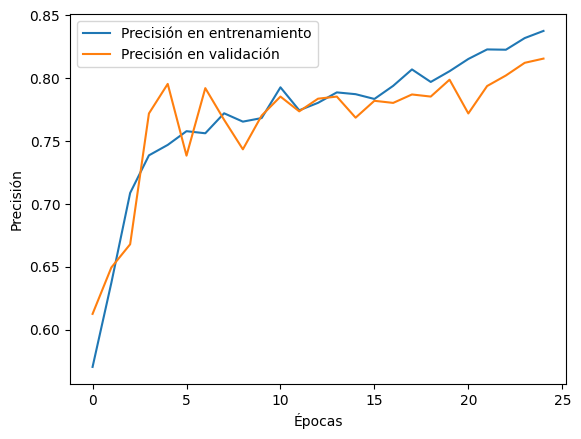

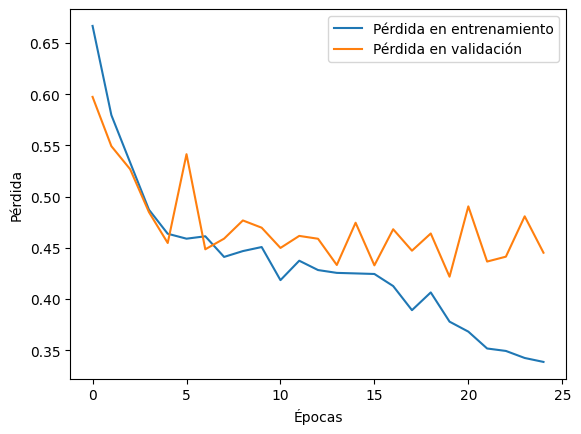

In [15]:
# Curvas de precisión
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Curvas de pérdida
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Matriz de Confusión:
[[620 103]
 [152 336]]
Reporte de Clasificación:

              precision    recall  f1-score   support

     Benigna       0.80      0.86      0.83       723
     Maligna       0.77      0.69      0.72       488

    accuracy                           0.79      1211
   macro avg       0.78      0.77      0.78      1211
weighted avg       0.79      0.79      0.79      1211

AUC-ROC: 0.87


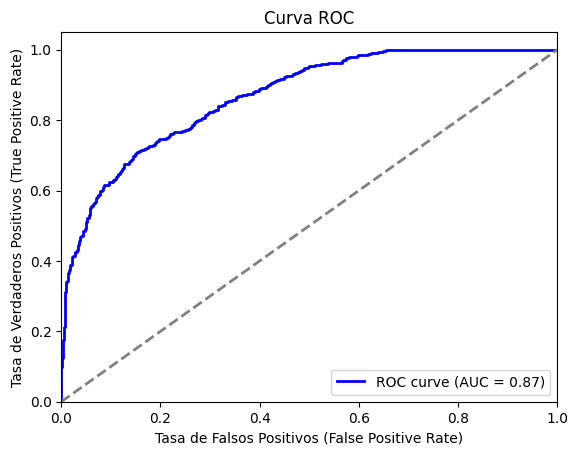

In [18]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Paso 1: Predicción de probabilidades y clases
y_pred_proba = model_cnn_simple.predict(X_test)  # Probabilidades de que la clase sea "maligna"
y_pred_classes = (y_pred_proba > 0.5).astype("int32")  # Convertir a etiquetas de clase usando un umbral de 0.5

# Paso 2: Matriz de Confusión
cm = confusion_matrix(y_test_binary, y_pred_classes)
print("Matriz de Confusión:")
print(cm)

# Paso 3: Reporte de Clasificación (Precisión, Recall, F1)
print("Reporte de Clasificación:\n")
print(classification_report(y_test_binary, y_pred_classes, target_names=["Benigna", "Maligna"]))

# Paso 4: Calcular AUC-ROC
roc_auc = roc_auc_score(y_test_binary, y_pred_proba)
print(f"AUC-ROC: {roc_auc:.2f}")

# Paso 5: Curva ROC
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (False Positive Rate)')
plt.ylabel('Tasa de Verdaderos Positivos (True Positive Rate)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()
